In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
plt.style.use('fivethirtyeight')

In [19]:
# import data set
train = pd.read_csv('train.csv',index_col=0, parse_dates=True)
test = pd.read_csv('test.csv',index_col=0, parse_dates=True)
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# prepare variables
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)
train.rename(columns={'new_cases': 'y'}, inplace=True)
test.rename(columns={'new_cases': 'y'}, inplace=True)
train.head()

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15032/2302885905.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train = pd.read_csv('train.csv',index_col=0, parse_dates=True)
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15032/2302885905.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test = pd.read_csv('test.csv',index_col=0, parse_dates=True)


,location,y,new_deaths,reproduction_rate,new_tests,stringency_index,population_density,aged_70_older,diabetes_prevalence,female_smokers,...,dayofyear,dayofmonth,weekofyear,new_cases_lag1,new_cases_lag7,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
date,,,,,,,,,,,,,,,,,,,,,
2020-03-21,Belgium,713.0,35.0,2.16,2276.0,81.48,375.564,12.849,4.29,25.1,...,81,21,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-22,Belgium,662.0,40.0,2.13,1414.0,81.48,375.564,12.849,4.29,25.1,...,82,22,12,713.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-23,Belgium,469.0,41.0,2.09,3322.0,81.48,375.564,12.849,4.29,25.1,...,83,23,13,662.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-24,Belgium,486.0,55.0,2.05,3975.0,81.48,375.564,12.849,4.29,25.1,...,84,24,13,469.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-25,Belgium,1328.0,81.0,2.01,4282.0,81.48,375.564,12.849,4.29,25.1,...,85,25,13,486.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# impute outliers in target varible 
from sklearn.preprocessing import RobustScaler
scalers = {}
for location, train_country_data in train.groupby('location'):
    scaler = RobustScaler()
    scaler.fit(train_country_data[['y']])
    train.loc[train['location'] == location, 'y_scaled'] = scaler.transform(train_country_data[['y']])
    # apply to test
    test_country_data = test[test['location'] == location]
    test.loc[test['location'] == location, 'y_scaled'] = scaler.transform(test_country_data[['y']])
    scalers[location] = scaler

In [21]:
# set x_train
x_train = train.drop(columns=['y','y_scaled'])
y_train = train['y']
y_train_scaled = train['y_scaled']
x_test = test.drop(columns=['y','y_scaled'])
y_test = test['y']
y_test_scaled = test['y_scaled']
x_train.columns

Index(['location', 'new_deaths', 'reproduction_rate', 'new_tests',
       'stringency_index', 'population_density', 'aged_70_older',
       'diabetes_prevalence', 'female_smokers', 'life_expectancy',
       'human_development_index', 'population', 'holidays', 'season',
       'day_of_week', 'weekend', 'month', 'year', 'quarter', 'dayofyear',
       'dayofmonth', 'weekofyear', 'new_cases_lag1', 'new_cases_lag7',
       'new_cases_lag8', 'new_cases_roll_mean7', 'new_cases_roll_std7',
       'new_cases_roll_mean14', 'new_cases_roll_std14'],
      dtype='object')

In [23]:
# encode location since my xgb doesn't support enable_categorical
x_train = pd.get_dummies(x_train, columns=['location'])
x_test = pd.get_dummies(x_test, columns=['location'])

# encode holidays and season
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x_train['holidays'] = le.fit_transform(x_train['holidays'])
x_test['holidays'] = le.transform(x_test['holidays'])
x_train['season'] = le.fit_transform(x_train['season'])
x_test['season'] = le.transform(x_test['season'])
x_train['season'].head()

date
2020-03-21    1
2020-03-22    1
2020-03-23    1
2020-03-24    1
2020-03-25    1
Name: season, dtype: int64

In [25]:
x_train.dtypes

new_deaths                 float64
reproduction_rate          float64
new_tests                  float64
stringency_index           float64
population_density         float64
aged_70_older              float64
diabetes_prevalence        float64
female_smokers             float64
life_expectancy            float64
human_development_index    float64
population                   int64
holidays                     int64
season                       int64
day_of_week                  int64
weekend                      int64
month                        int64
year                         int64
quarter                      int64
dayofyear                    int64
dayofmonth                   int64
weekofyear                   int64
new_cases_lag1             float64
new_cases_lag7             float64
new_cases_lag8             float64
new_cases_roll_mean7       float64
new_cases_roll_std7        float64
new_cases_roll_mean14      float64
new_cases_roll_std14       float64
location_Belgium    

## Experiment with Robust Scaler

### Italy

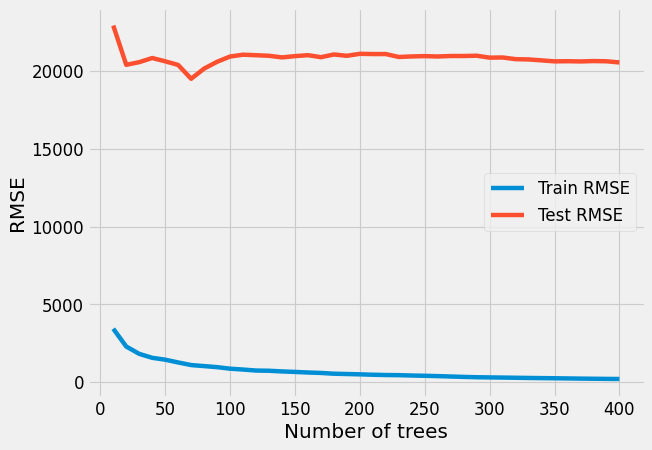

In [26]:
# visualize change in rmse with n_estimators, code for stat303_3 modified
train_rmse = {}
test_rmse = {}

for i in np.linspace(10, 400, 40, dtype=int):
    model = xgb.XGBRegressor(n_estimators=i, random_state=1).fit(x_train, y_train_scaled)
    
    train_pred_scaled = model.predict(x_train)
    train_pred = np.concatenate([scalers[location].inverse_transform(train_pred_scaled[train['location'] == location].reshape(-1, 1)) 
                                 for location in scalers.keys()])
    test_pred_scaled = model.predict(x_test)
    test_pred = np.concatenate([scalers[location].inverse_transform(test_pred_scaled[test['location'] == location].reshape(-1, 1)) 
                                for location in scalers.keys()])

    train_rmse[i] = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse[i] = np.sqrt(mean_squared_error(y_test, test_pred))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(train_rmse.keys()), list(train_rmse.values()), label='Train RMSE')
plt.plot(list(test_rmse.keys()), list(test_rmse.values()), label='Test RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [27]:
model = xgb.XGBRegressor(enable_categorical = True,
                         learning_rate=0.01, 
                         max_depth=4, 
                         n_estimators=500, 
                         n_jobs=-1, 
                         random_state=0)
model.fit(x_train, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=0, ...)

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15032/975475265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_italy['yhat_inversed'] = italy_scaler.inverse_transform(subset_italy['yhat'].values.reshape(-1, 1))
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_15032/975475265.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_italy['yhat_inversed'] = italy_scaler.inverse_transform(subset_italy['yhat'].values.reshape(-1, 1))


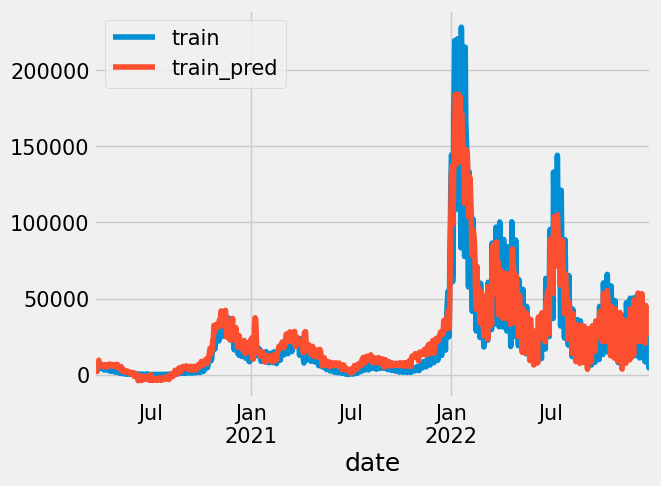

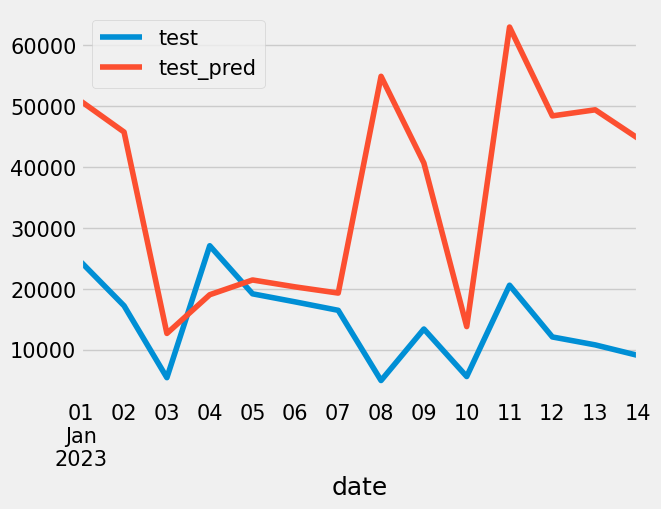

In [50]:
train_pred=pd.DataFrame((model.predict(x_train)), columns=['yhat'], index=train.index)
train_combined = pd.concat([x_train,train['y'],train_pred['yhat']], axis=1)
subset_italy = train_combined[train_combined['location_Italy'] == 1]
italy_scaler = scalers['Italy']
subset_italy['yhat_inversed'] = italy_scaler.inverse_transform(subset_italy['yhat'].values.reshape(-1, 1))
pd.concat([subset_italy['y'], subset_italy['yhat_inversed']], axis=1).plot()
plt.legend(['train', 'train_pred'])
test_pred=pd.DataFrame((model.predict(x_test)), columns=['yhat'], index=test.index)
test_combined = pd.concat([x_test,y_test,test_pred['yhat']], axis=1)
subset_italy = test_combined[test_combined['location_Italy'] == 1]
subset_italy['yhat_inversed'] = italy_scaler.inverse_transform(subset_italy['yhat'].values.reshape(-1, 1))
pd.concat([subset_italy['y'], subset_italy['yhat_inversed']], axis=1).plot()
plt.legend(['test', 'test_pred'])

## Model Development (without scaler)

### Italy

Train RMSE: 2569.09484480003
Test RMSE: 3599.195339359328


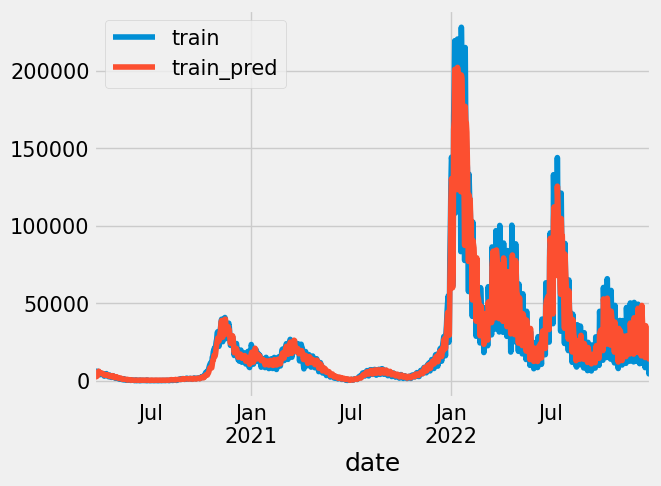

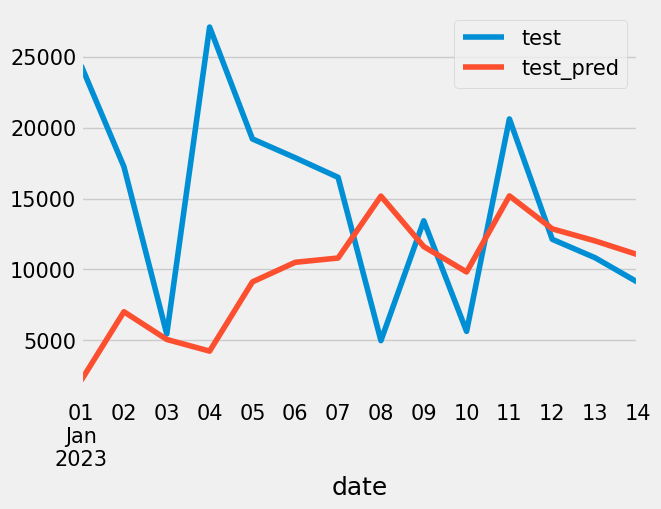

In [51]:
model2 = xgb.XGBRegressor(enable_categorical = True,
                          learning_rate=0.01, 
                          max_depth=3, 
                          n_estimators=500, 
                          n_jobs=-1, 
                          random_state=0)
model2.fit(x_train, y_train)

train_pred=pd.DataFrame((model2.predict(x_train)), columns=['yhat'], index=train.index)
train_combined = pd.concat([x_train,y_train,train_pred['yhat']], axis=1)
subset_italy = train_combined[train_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['train', 'train_pred'])

test_pred=pd.DataFrame((model2.predict(x_test)), columns=['yhat'], index=test.index)
test_combined = pd.concat([x_test,y_test,test_pred['yhat']], axis=1)
subset_italy = test_combined[test_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')



## Grid Search

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [35]:
#K-fold cross validation to find optimal parameters for XGBoost
import time
from sklearn.model_selection import KFold, RandomizedSearchCV

# Assuming x_train and y_train are already defined and properly formatted for multivariate analysis
start_time = time.time()

param_grid = {'max_depth': [4, 6, 8],
              'learning_rate': [0.01, 0.05, 0.1],
              'reg_lambda': [0, 1, 10],
            #   'n_estimators': [100, 500, 1000],
              'gamma': [0, 10, 100],
              'subsample': [0.5, 0.75, 1.0],
              'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5, shuffle=True, random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1, n_estimators=200),
                                    param_distributions=param_grid, n_iter=200,
                                    verbose=1, n_jobs=-1, cv=cv,
                                    scoring='neg_root_mean_squared_error') # Setting RMSE as the evaluation metric
optimal_params.fit(x_train, y_train)

print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross-validation RMSE =", optimal_params.best_score_)
print("Time taken = ", round((time.time() - start_time) / 60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 0, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 100, 'colsample_bytree': 0.75}
Optimal cross-validation RMSE = -3098.735252232762
Time taken =  1  minutes


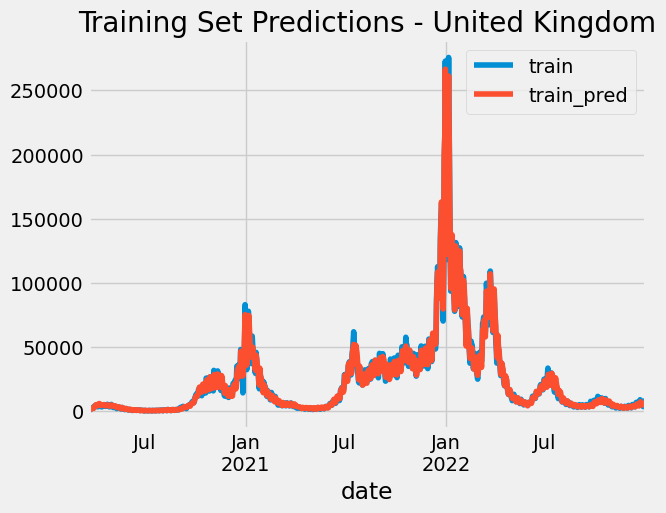

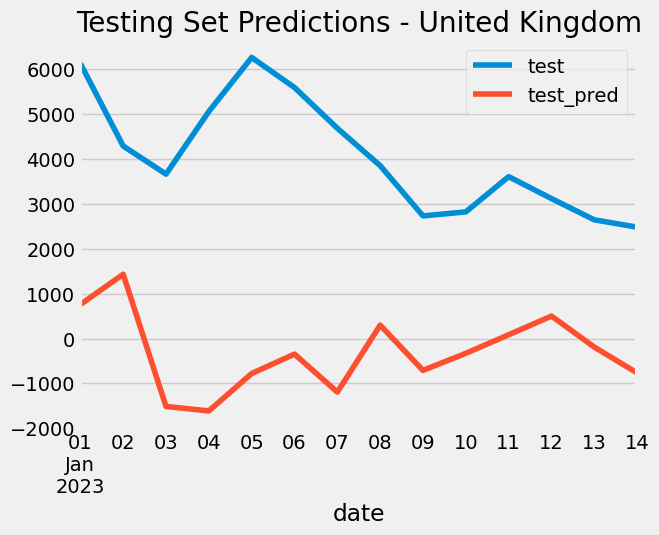

United Kingdom - Train RMSE: 2376.527808848483
United Kingdom - Test RMSE: 4626.932444129635


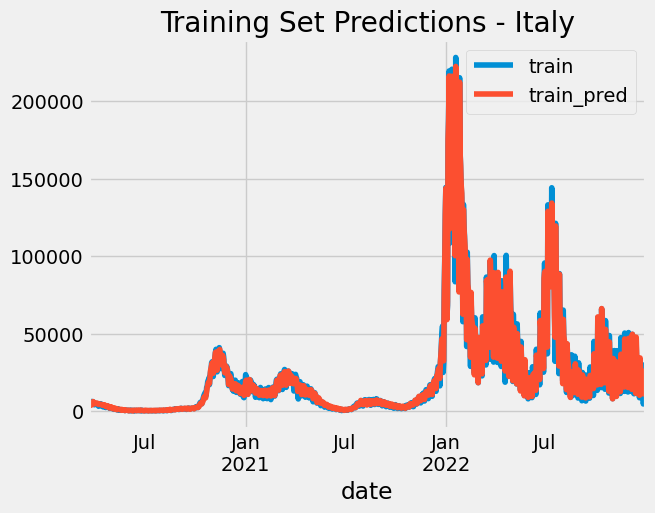

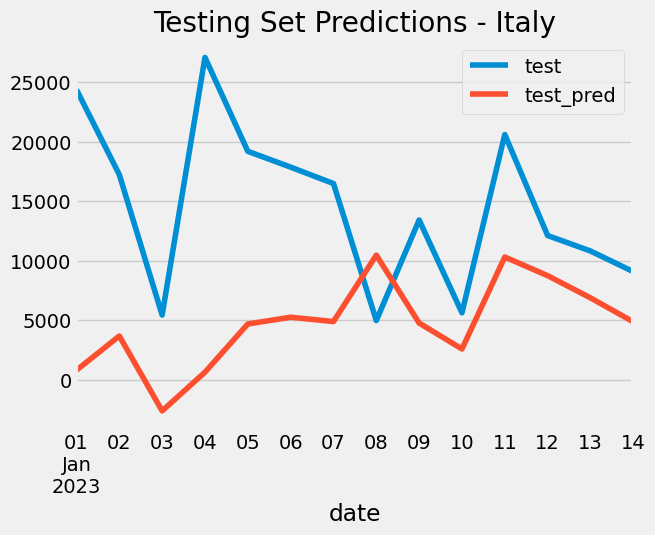

Italy - Train RMSE: 2762.7765166029208
Italy - Test RMSE: 12757.548933123902


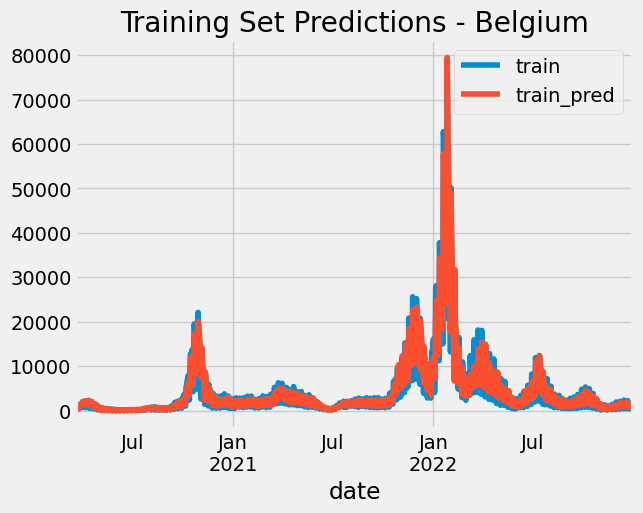

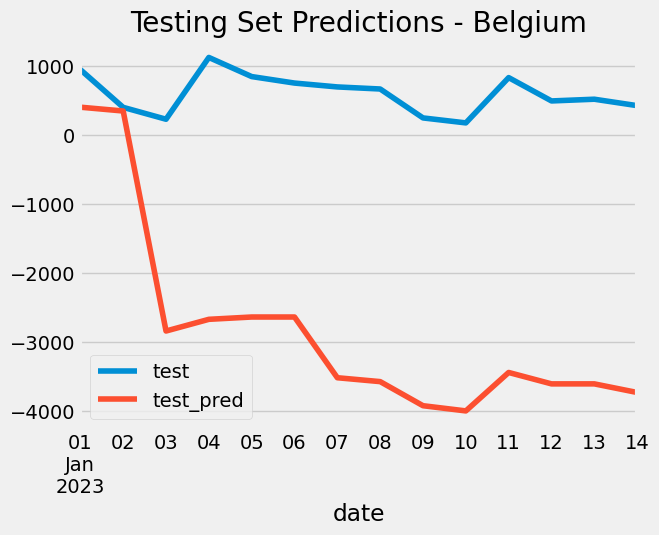

Belgium - Train RMSE: 1239.2244200135583
Belgium - Test RMSE: 3660.1551336192138


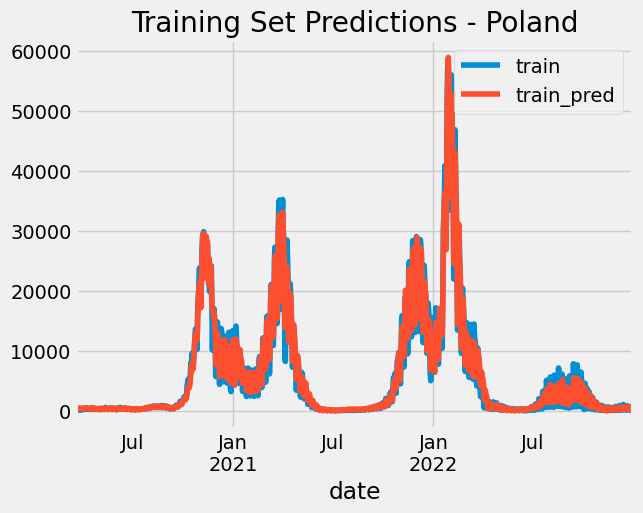

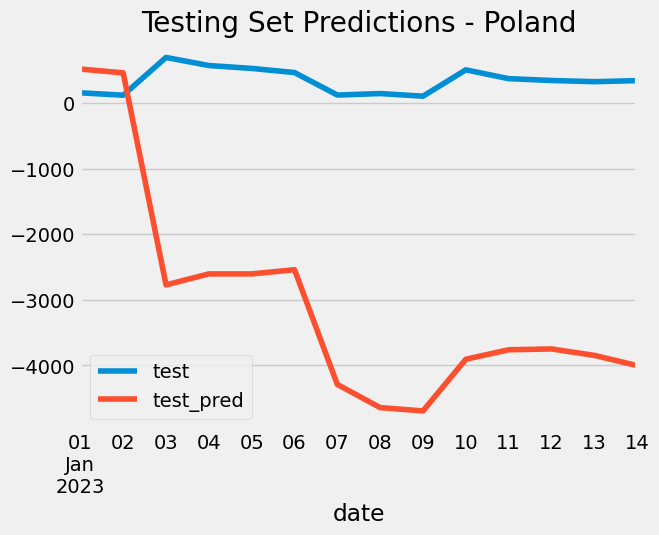

Poland - Train RMSE: 1178.0313992445476
Poland - Test RMSE: 3741.5279021443416


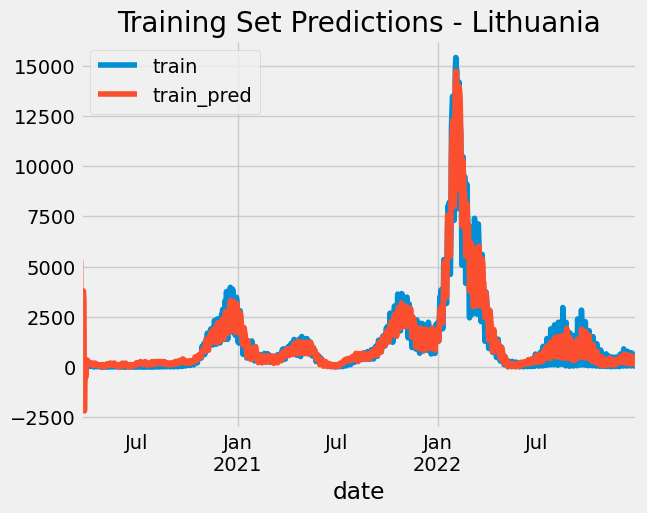

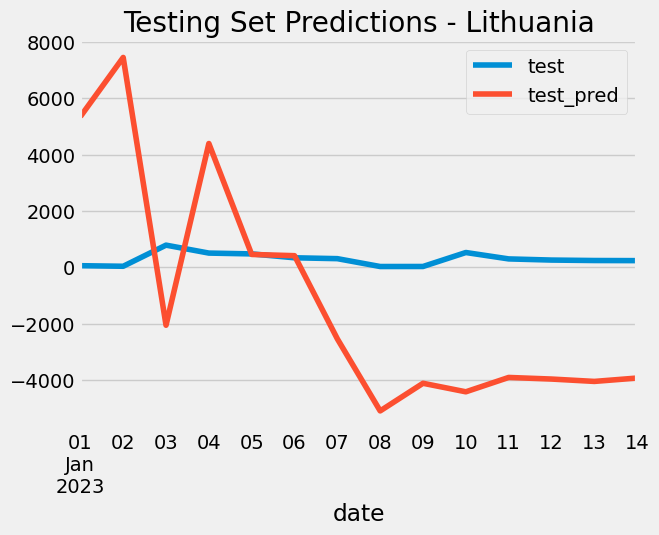

Lithuania - Train RMSE: 436.7009312439763
Lithuania - Test RMSE: 4256.609257429072


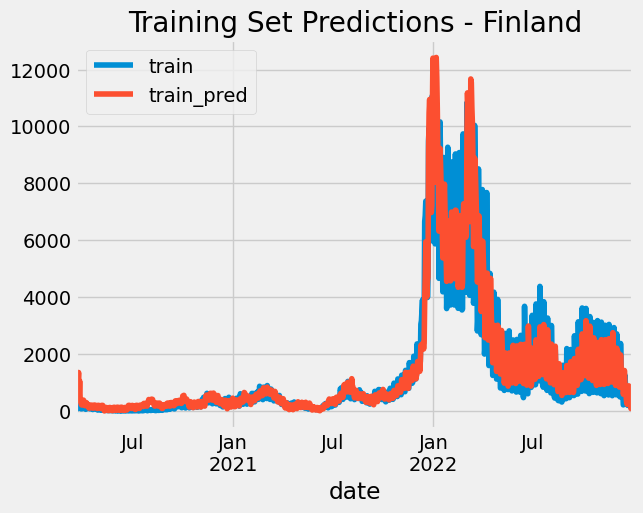

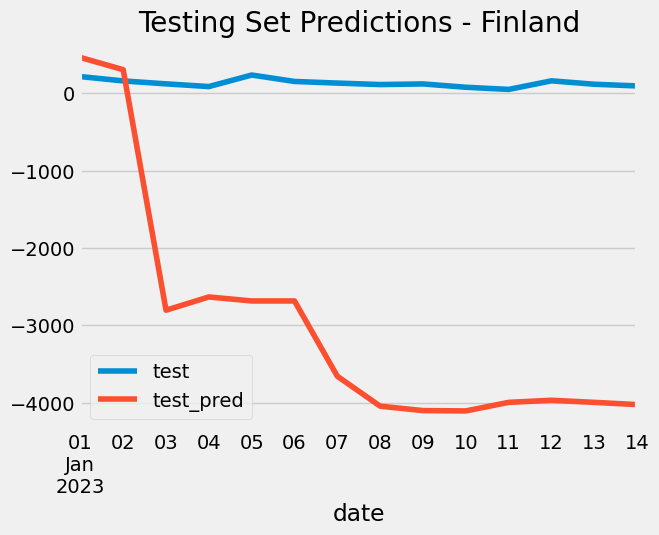

Finland - Train RMSE: 552.4305764339532
Finland - Test RMSE: 3453.4449873960907


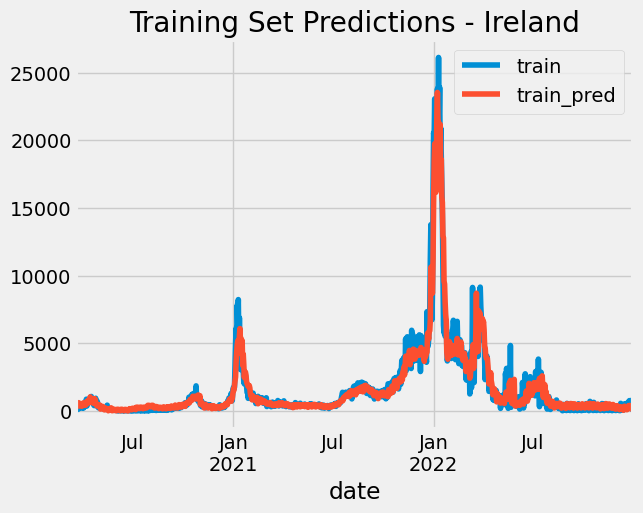

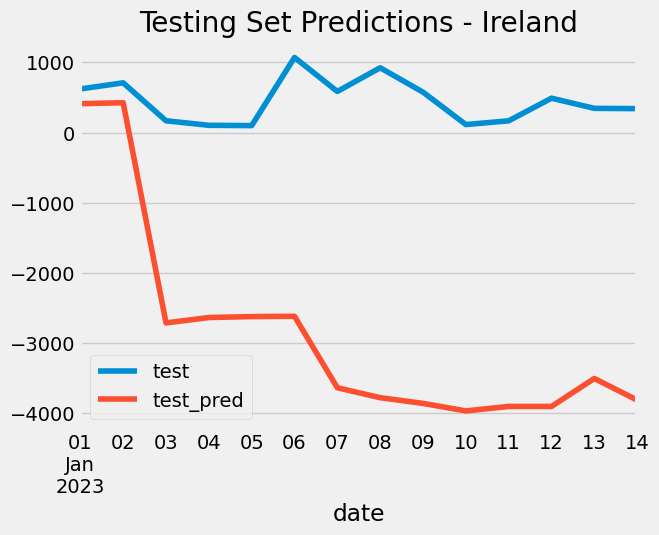

Ireland - Train RMSE: 738.8779072341426
Ireland - Test RMSE: 3600.336256011897


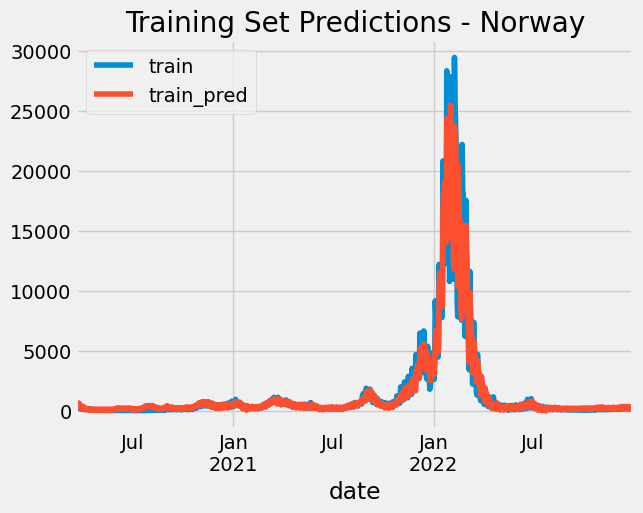

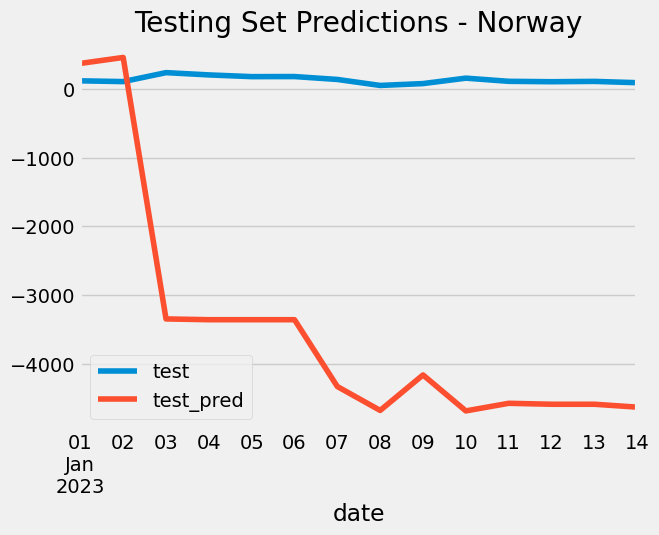

Norway - Train RMSE: 583.4904423665098
Norway - Test RMSE: 3981.9027971689143


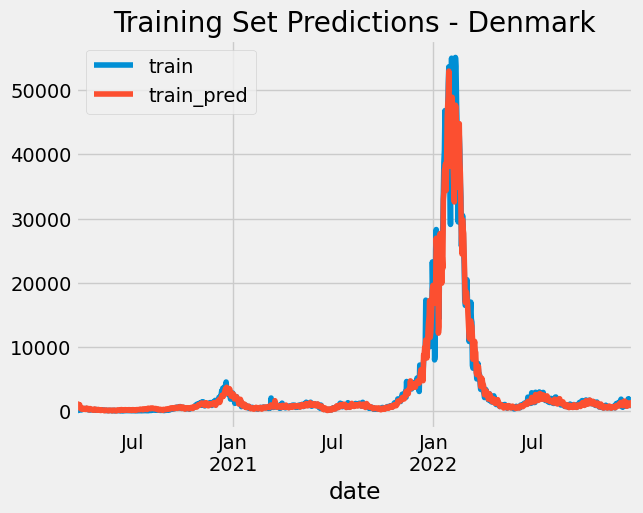

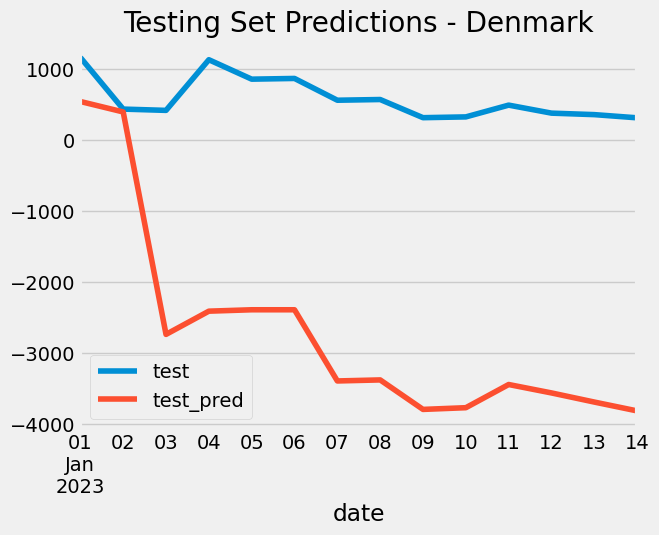

Denmark - Train RMSE: 1158.9483675076492
Denmark - Test RMSE: 3522.3528778500695


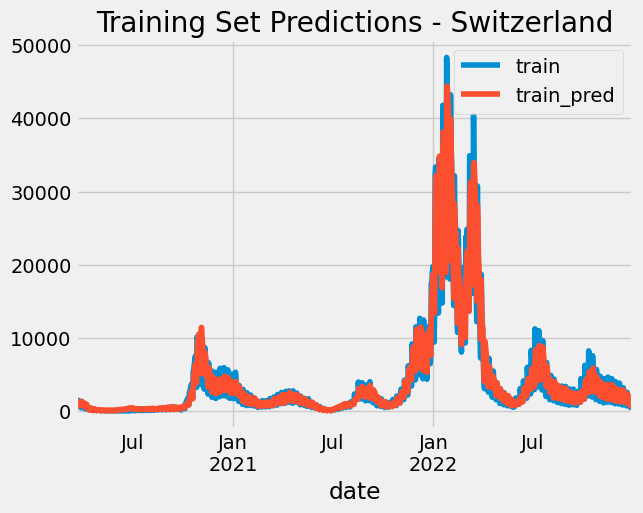

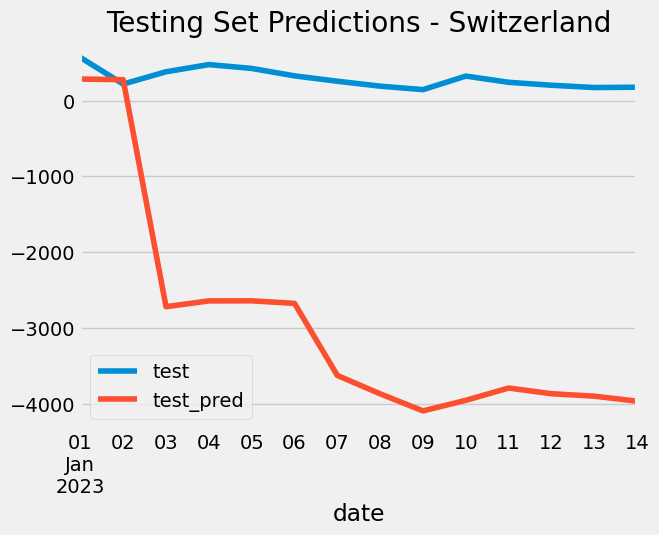

Switzerland - Train RMSE: 1103.1497772597213
Switzerland - Test RMSE: 3509.7977150069314
                 train_rmse     test_rmse
United Kingdom  2376.527809   4626.932444
Italy           2762.776517  12757.548933
Belgium         1239.224420   3660.155134
Poland          1178.031399   3741.527902
Lithuania        436.700931   4256.609257
Finland          552.430576   3453.444987
Ireland          738.877907   3600.336256
Norway           583.490442   3981.902797
Denmark         1158.948368   3522.352878
Switzerland     1103.149777   3509.797715


In [61]:
model3 = xgb.XGBRegressor(enable_categorical = True,
                          subsample = 0.75,
                          reg_lambda = 0,
                          max_depth = 4, 
                          learning_rate=0.1, 
                          gamma = 100,
                          colsample_bytree = 0.75,
                          n_jobs=-1, 
                          random_state=0)
model3.fit(x_train, y_train)

countries = ['United Kingdom', 'Italy', 'Belgium', 'Poland','Lithuania','Finland', 'Ireland', 'Norway', 'Denmark','Switzerland']
rmse_results = {}

for country in countries:
    location_column = f'location_{country}'

    # train set preds
    train_pred = pd.DataFrame(model3.predict(x_train), columns=['yhat'], index=train.index)
    train_combined = pd.concat([x_train, y_train, train_pred['yhat']], axis=1)
    subset_country_train = train_combined[train_combined[location_column] == 1]

    subset_country_train[['y', 'yhat']].plot()
    plt.title(f'Training Set Predictions - {country}')
    plt.legend(['train', 'train_pred'])
    plt.show()

    # test set preds
    test_pred = pd.DataFrame(model3.predict(x_test), columns=['yhat'], index=test.index)
    test_combined = pd.concat([x_test, y_test, test_pred['yhat']], axis=1)
    subset_country_test = test_combined[test_combined[location_column] == 1]

    subset_country_test[['y', 'yhat']].plot()
    plt.title(f'Testing Set Predictions - {country}')
    plt.legend(['test', 'test_pred'])
    plt.show()

    # Calculate and print RMSE for training and testing sets
    train_rmse = sqrt(mean_squared_error(subset_country_train['y'], subset_country_train['yhat']))
    test_rmse = sqrt(mean_squared_error(subset_country_test['y'], subset_country_test['yhat']))
    rmse_results[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
    
    print(f'{country} - Train RMSE: {train_rmse}')
    print(f'{country} - Test RMSE: {test_rmse}')
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)


## Early Stopping

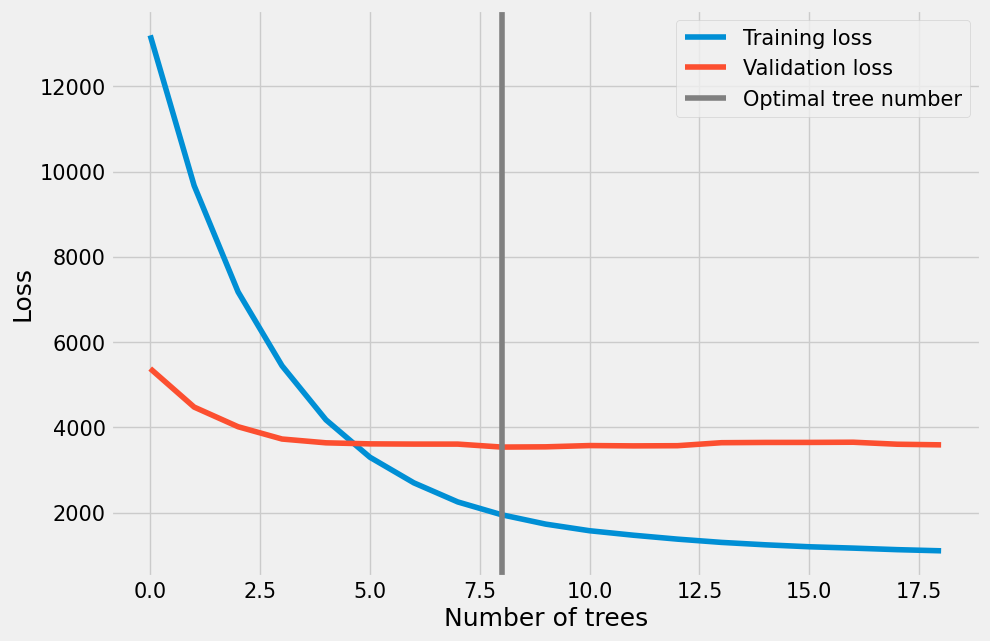

In [53]:
model4 = xgb.XGBRegressor(learning_rate=0.3,n_estimators=500, early_stopping_rounds=10,
                       enable_categorical=True)
model4.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)], 
       verbose=False)

results = model4.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model4.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [54]:
model4.best_iteration

8

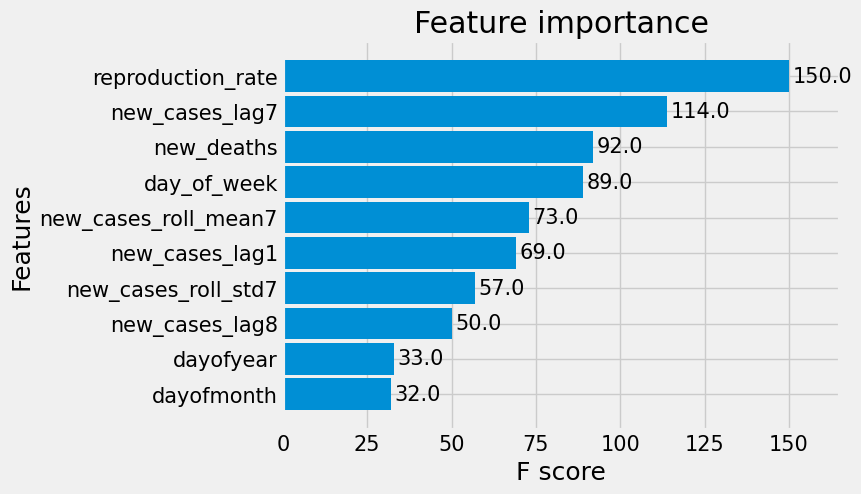

In [55]:
_ = plot_importance(model4, height=0.9 ,max_num_features = 10)

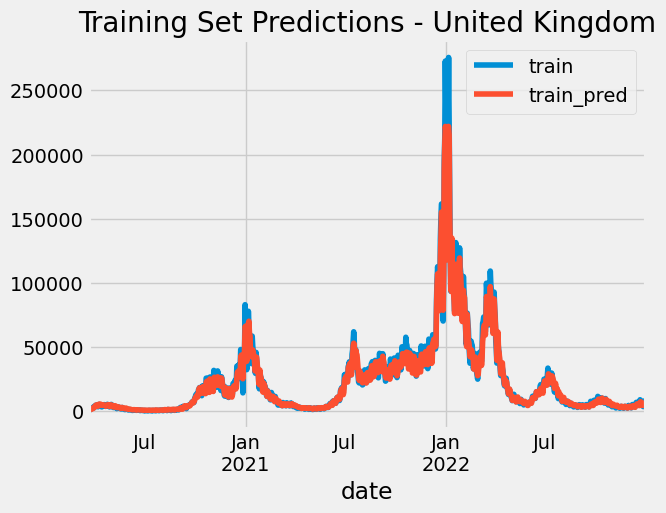

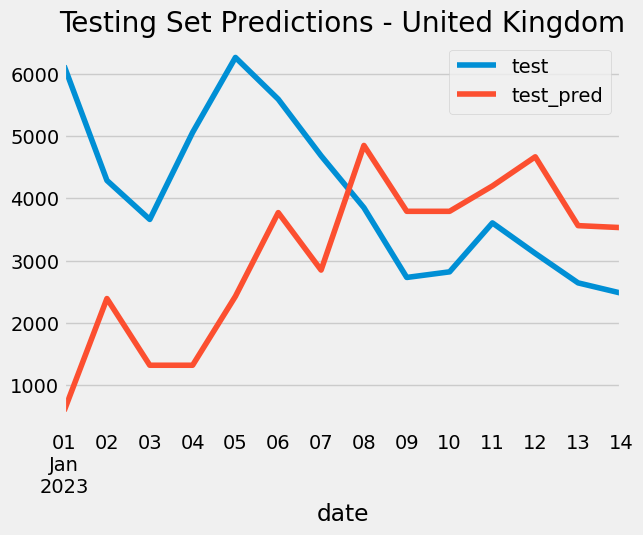

United Kingdom - Train RMSE: 3865.9398537135635
United Kingdom - Test RMSE: 2431.359643798582


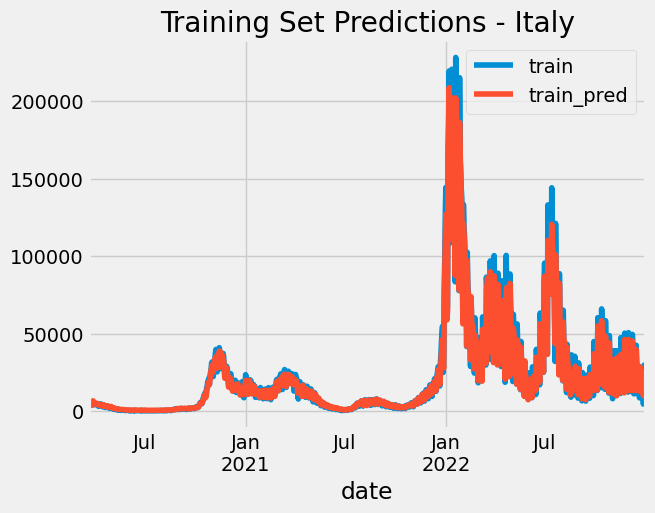

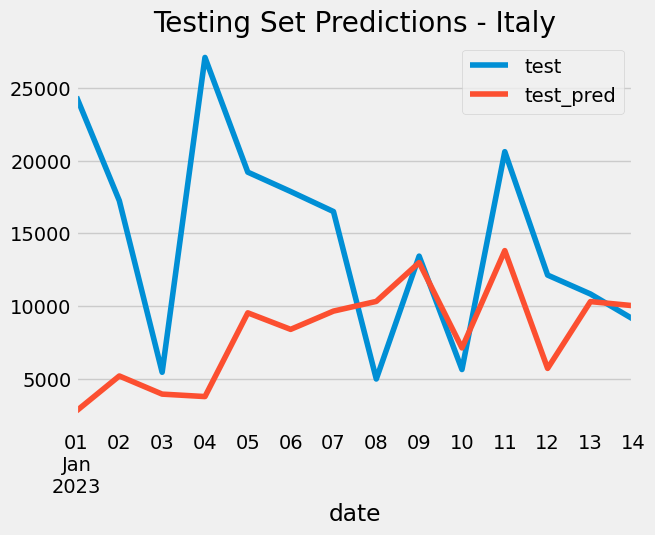

Italy - Train RMSE: 3893.756472017338
Italy - Test RMSE: 10388.784979211021


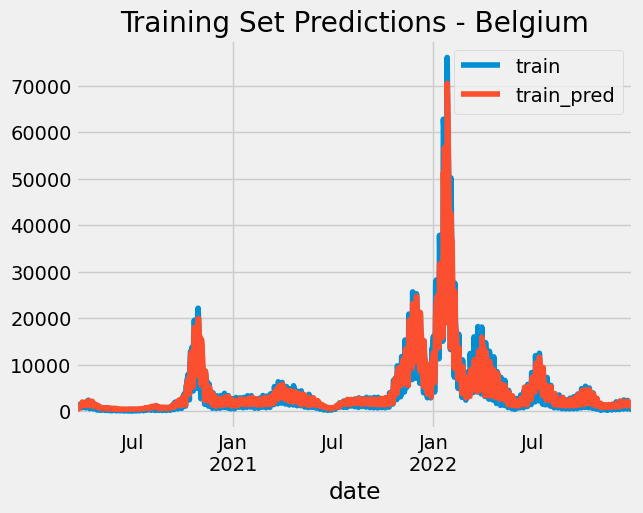

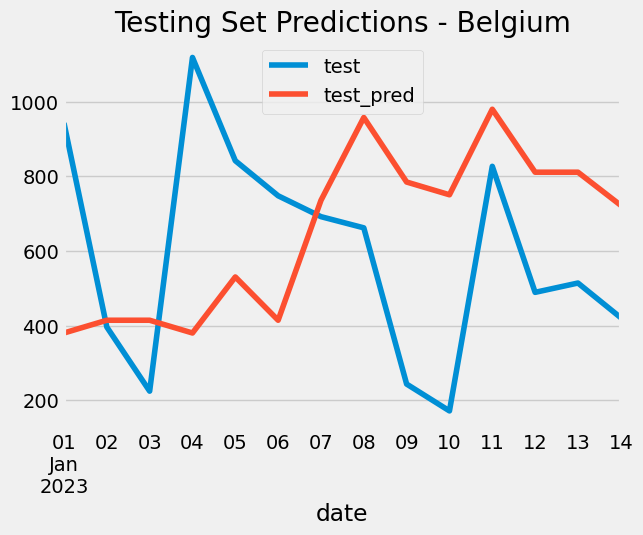

Belgium - Train RMSE: 1300.2276386978535
Belgium - Test RMSE: 390.40660484859796


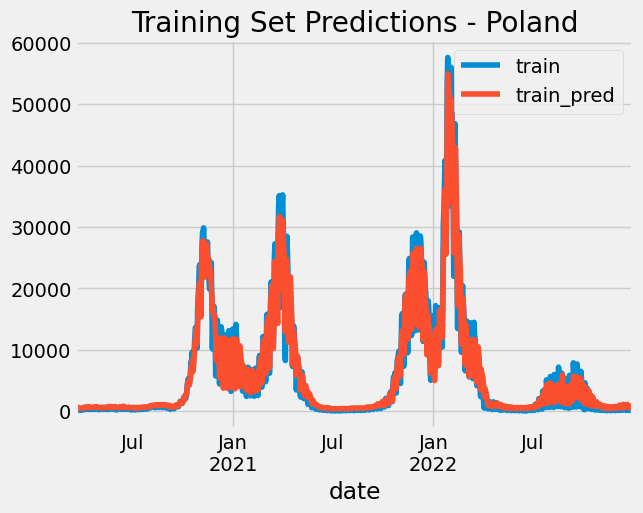

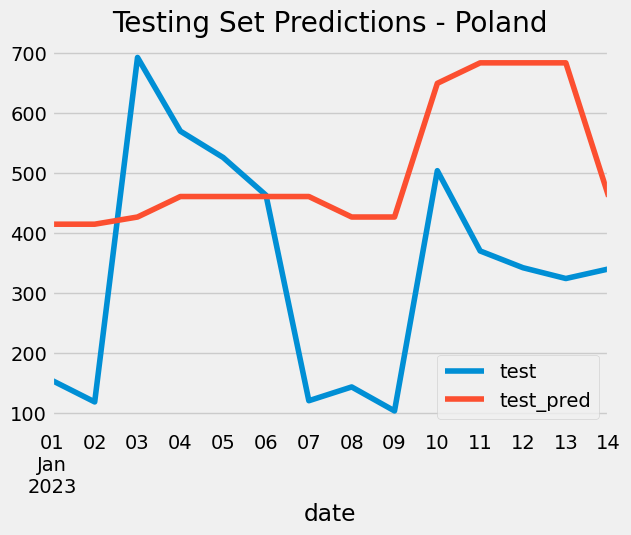

Poland - Train RMSE: 1356.6028949546514
Poland - Test RMSE: 257.1152796945397


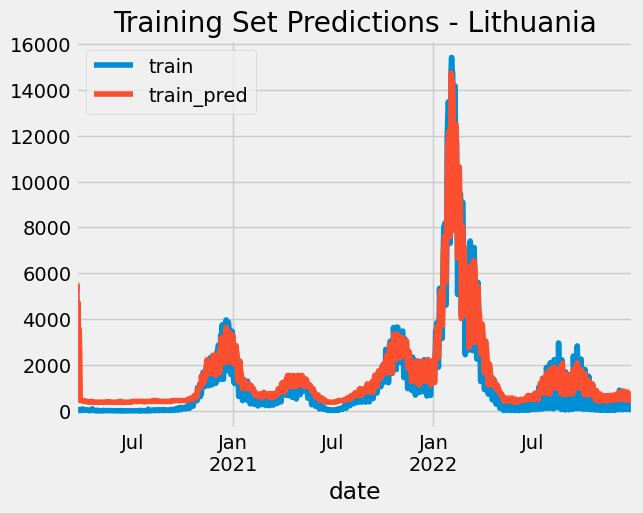

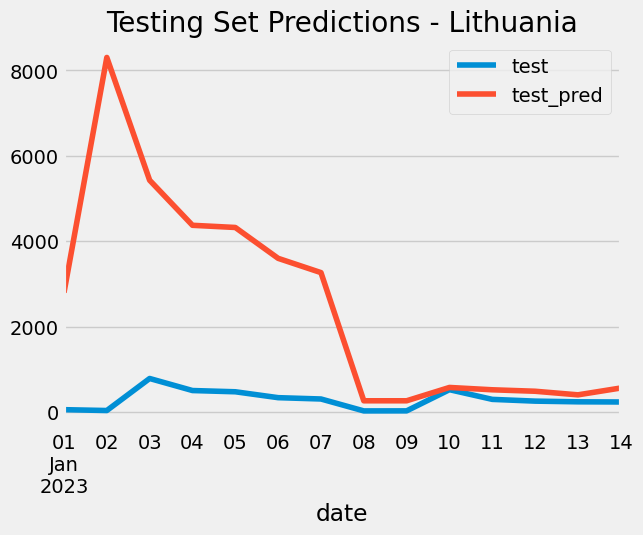

Lithuania - Train RMSE: 568.1325596204464
Lithuania - Test RMSE: 3239.3050903134213


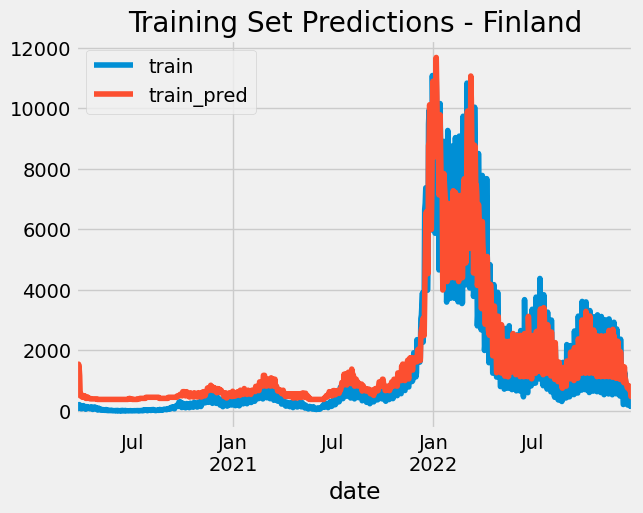

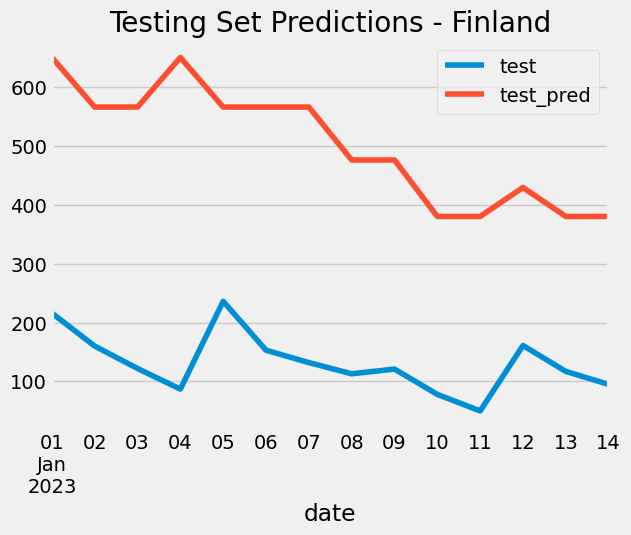

Finland - Train RMSE: 528.3799877993912
Finland - Test RMSE: 379.21196247067326


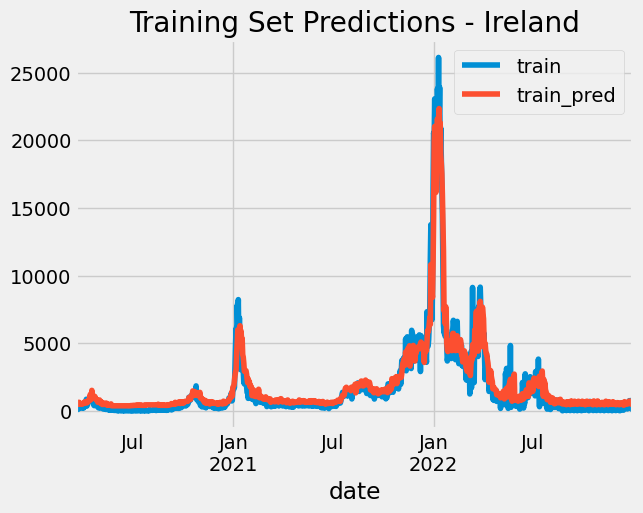

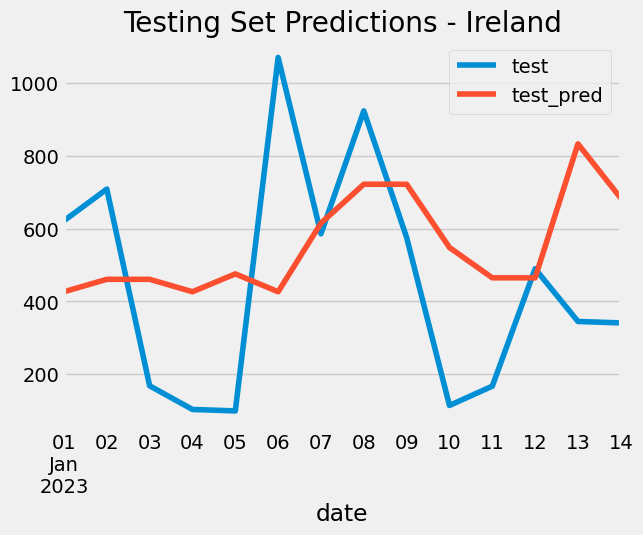

Ireland - Train RMSE: 738.209652887669
Ireland - Test RMSE: 332.1611534806843


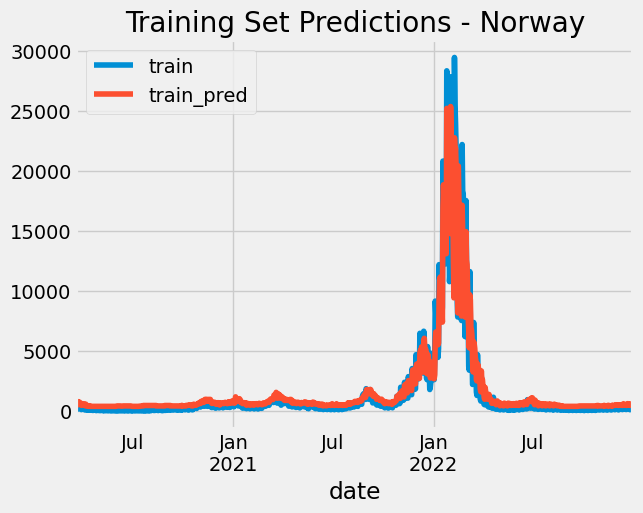

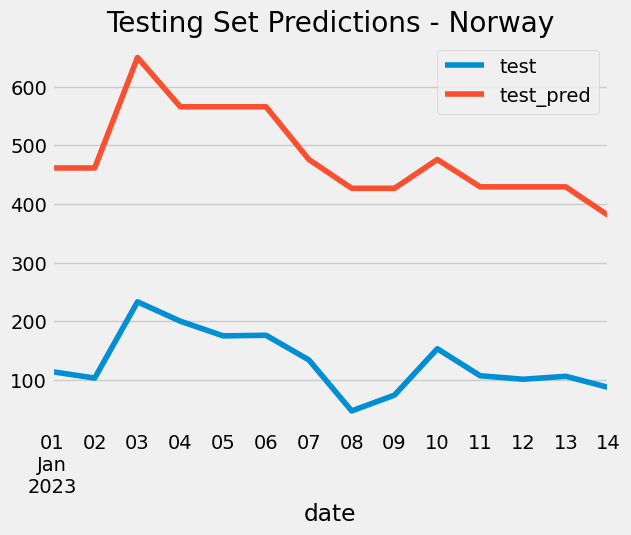

Norway - Train RMSE: 694.1834263251592
Norway - Test RMSE: 353.77661343667035


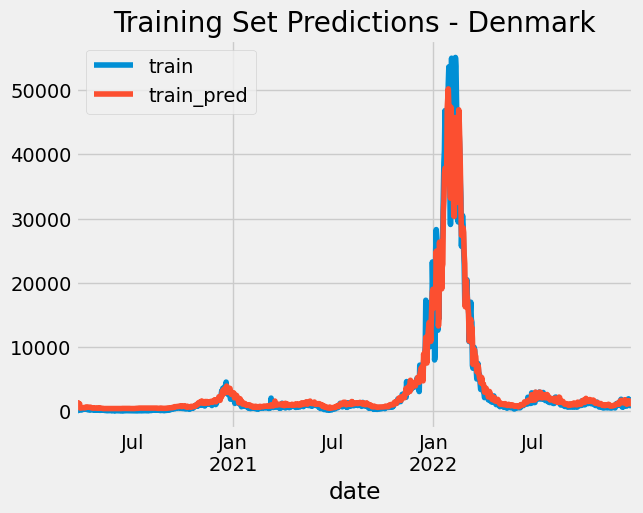

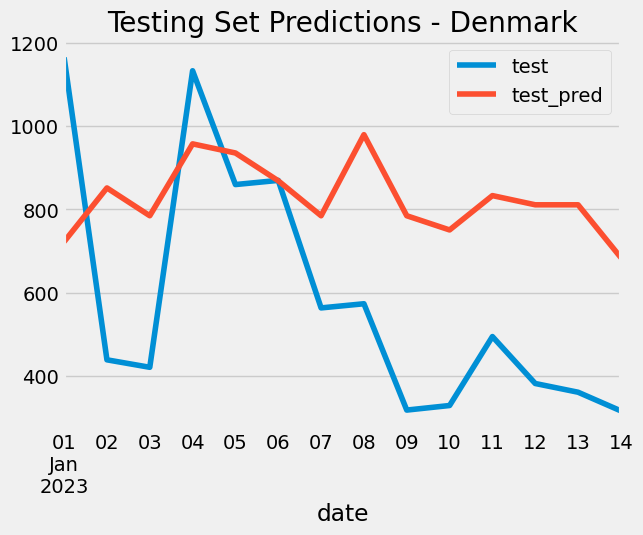

Denmark - Train RMSE: 1251.9205526821847
Denmark - Test RMSE: 357.6341367354147


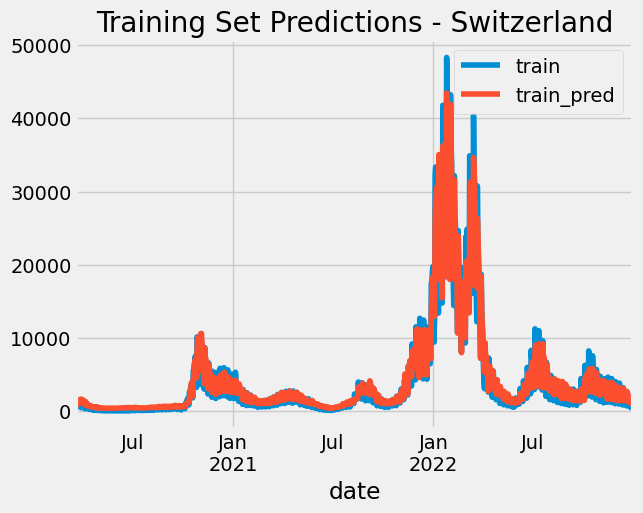

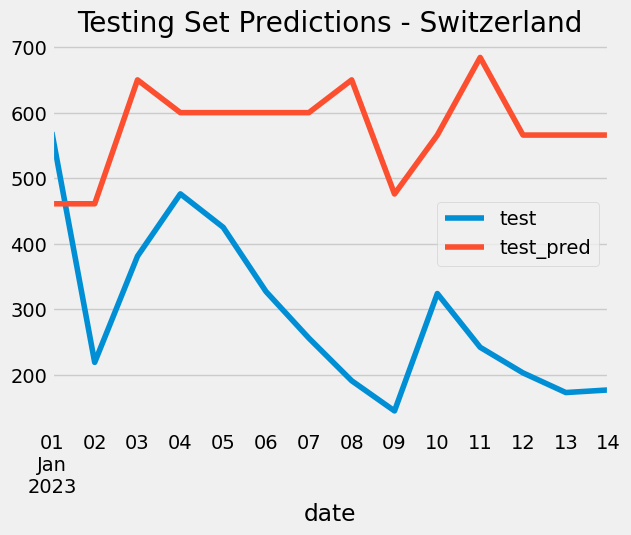

Switzerland - Train RMSE: 1080.2667806186687
Switzerland - Test RMSE: 315.29170809872096
                 train_rmse     test_rmse
United Kingdom  3865.939854   2431.359644
Italy           3893.756472  10388.784979
Belgium         1300.227639    390.406605
Poland          1356.602895    257.115280
Lithuania        568.132560   3239.305090
Finland          528.379988    379.211962
Ireland          738.209653    332.161153
Norway           694.183426    353.776613
Denmark         1251.920553    357.634137
Switzerland     1080.266781    315.291708


In [60]:
countries = ['United Kingdom', 'Italy', 'Belgium', 'Poland','Lithuania','Finland', 'Ireland', 'Norway', 'Denmark','Switzerland']
rmse_results = {}

for country in countries:
    location_column = f'location_{country}'

    # train set preds
    train_pred = pd.DataFrame(model4.predict(x_train), columns=['yhat'], index=train.index)
    train_combined = pd.concat([x_train, y_train, train_pred['yhat']], axis=1)
    subset_country_train = train_combined[train_combined[location_column] == 1]

    subset_country_train[['y', 'yhat']].plot()
    plt.title(f'Training Set Predictions - {country}')
    plt.legend(['train', 'train_pred'])
    plt.show()

    # test set preds
    test_pred = pd.DataFrame(model4.predict(x_test), columns=['yhat'], index=test.index)
    test_combined = pd.concat([x_test, y_test, test_pred['yhat']], axis=1)
    subset_country_test = test_combined[test_combined[location_column] == 1]

    subset_country_test[['y', 'yhat']].plot()
    plt.title(f'Testing Set Predictions - {country}')
    plt.legend(['test', 'test_pred'])
    plt.show()

    # Calculate and print RMSE for training and testing sets
    train_rmse = sqrt(mean_squared_error(subset_country_train['y'], subset_country_train['yhat']))
    test_rmse = sqrt(mean_squared_error(subset_country_test['y'], subset_country_test['yhat']))
    rmse_results[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
    
    print(f'{country} - Train RMSE: {train_rmse}')
    print(f'{country} - Test RMSE: {test_rmse}')
    
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)